# **Practica 3: Clasificación por árboles de decisión**

## Alumno: Cano Portugal Israel Daniel Arturo
## Profesor: Jiménez Alcantar Daniel
## Grupo: 5AV1
## Materia: Aprendizaje a Maquina e Inteligencia Artificial

In [1]:
# Instalación (solo una vez)
!pip install yfinance

In [3]:
# Importaciones
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
# Descarga datos de AAPL
ticker = 'AAPL'
start_date = '2010-01-01'  # Ajusta según tus necesidades
end_date = datetime.now().strftime('%Y-%m-%d')  # Hasta hoy (10/10/2025)

# Descarga
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Asegura que el índice sea una columna 'Date'
data = data.reset_index()

# Verifica las columnas
print("Columnas del DataFrame:", data.columns)

# Muestra las primeras filas
print("\nPrimeras filas del DataFrame:")
display(data.head())

# Guarda en CSV limpio
data.to_csv('precios_aapl_diarios.csv', index=False)
print(f"\nDatos guardados en 'precios_aapl_diarios.csv' con {len(data)} observaciones.")

/tmp/ipython-input-3973317986.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed

Columnas del DataFrame: MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

Primeras filas del DataFrame:


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2010-01-04,6.424605,6.439315,6.375672,6.407193,493729600
1,2010-01-05,6.435714,6.472038,6.401791,6.442318,601904800
2,2010-01-06,6.333344,6.461230,6.326740,6.435713,552160000
3,2010-01-07,6.321635,6.364264,6.275704,6.356759,477131200
4,2010-01-08,6.363663,6.364264,6.276005,6.313229,447610800



Datos guardados en 'precios_aapl_diarios.csv' con 3968 observaciones.


### **1. Introducción**
Los algoritmos de Vecinos Más Cercanos (K-Nearest Neighbors, KNN) son métodos no paramétricos de clasificación que asignan una etiqueta a una nueva observación basándose en las clases de las k observaciones más similares en el conjunto de entrenamiento. A diferencia de los modelos basados en árboles, KNN no construye una regla explícita; en cambio, almacena todo el conjunto de datos y realiza predicciones mediante comparación de distancias.

Aunque KNN es simple y efectivo en muchos contextos, su aplicación a series de tiempo presenta desafíos: los datos son secuenciales, autocorrelacionados y sensibles al orden temporal. Para superar esto, se transforma la serie en un problema de clasificación supervisada mediante ingeniería de características, como rezagos (lags), promedios móviles y volatilidad histórica.

En esta práctica, se aplica KNN a los precios diarios de las acciones de Apple Inc. (AAPL) desde 2010 hasta 2025, con el objetivo de clasificar si el precio subirá o bajará al día siguiente. Se evalúan distintas configuraciones del algoritmo (número de vecinos, métricas de distancia, ponderación por distancia) y se compara su desempeño usando métricas de clasificación como precisión, recall, F1 y AUC-ROC. Todo el proceso sigue la metodología CRISP-DM para garantizar rigor y reproducibilidad.

### **2. Problemática**
El mercado accionario es un sistema dinámico, ruidoso y altamente volátil, donde predecir el comportamiento futuro de los precios representa un reto constante. En particular, para empresas como Apple Inc. (AAPL), cuyas acciones son seguidas globalmente, existe un interés tanto académico como práctico en responder preguntas como:

**“¿Subirá o bajará el precio de la acción mañana?”**

Este tipo de pregunta no requiere predecir un valor exacto, sino clasificar la dirección del movimiento, lo que la convierte en un problema de clasificación binaria.

Sin embargo, los métodos tradicionales de series de tiempo (como ARIMA o modelos GARCH) asumen estructuras lineales o estocásticas específicas, y no siempre capturan patrones no lineales o dependencias complejas en los datos. Por otro lado, algoritmos de aprendizaje automático como los árboles de decisión —aunque interpretables— pueden no ser óptimos en contextos donde la similitud local entre patrones históricos es más informativa que reglas globales.

En este contexto, surge la pregunta:

*¿Es posible utilizar el algoritmo de Vecinos Más Cercanos (KNN) para clasificar correctamente la dirección del precio de AAPL al día siguiente, transformando la serie de tiempo en un conjunto de características basadas en el pasado reciente?*

El reto principal radica en que KNN es sensible a la escala de las variables, a la dimensionalidad y a la estructura temporal de los datos. Si no se preparan adecuadamente las características (como rezagos, promedios móviles o volatilidad), el modelo puede comparar observaciones no comparables o sobreajustar al ruido del mercado.

Así, la problemática concreta es:

*¿Cómo transformar la serie de tiempo de precios de Apple en un conjunto de características numéricas normalizadas y significativas, para que el algoritmo KNN pueda clasificar de forma robusta si el precio subirá o bajar*

### **3. Metodología**
Para abordar la problemática planteada, se sigue la metodología CRISP-DM, adaptada al contexto de clasificación con el algoritmo K-Nearest Neighbors (KNN). Esta práctica explora una alternativa válida: KNN para clasificación en series de tiempo financieras.

---

**Transformación del problema**
La serie de tiempo de precios de Apple se convierte en un problema de clasificación binaria supervisada mediante:

Definición de la variable objetivo: 1 si el precio sube al día siguiente, 0 si baja o se mantiene.
Generación de características predictoras basadas en el pasado reciente:
* Rezagos del precio de cierre ($lag_1$, $lag_2$, etc.),
* Retornos diarios,
* Promedios móviles (5, 10 días),
* Volatilidad histórica (desviación estándar de retornos).

---

**Preparación para KNN**
El algoritmo KNN es sensible a:

* La escala de las variables: se aplica normalización (StandardScaler o MinMaxScaler).
* La dimensionalidad: se evitan demasiadas características para no sufrir la "maldición de la dimensionalidad".
* La estructura temporal: se garantiza que las características de cada fila provengan solo del pasado, evitando fuga de datos.

---
**Selección de modelos y configuraciones**

Se evalúan distintas configuraciones del algoritmo KNN:

Número de vecinos (k): desde 1 hasta 50 (con validación cruzada para elegir el óptimo).
Métricas de distancia: euclidiana, manhattan, minkowski.
Ponderación: uniforme vs. ponderada por distancia inversa.

---

**Validación y evaluación**

Se utiliza validación cruzada estratificada (5 folds) para estimar el desempeño.
Métricas de evaluación:
* Precisión, Recall, F1-score,
* Matriz de confusión,
* Curva ROC y AUC.

### **4. Modelo estadístico**
El modelo estadístico subyacente a esta práctica se basa en la transformación de una serie de tiempo financiera en un problema de clasificación binaria supervisada, con decisiones clave que garantizan robustez y compatibilidad con el algoritmo KNN.

**Definición de la variable objetivo (Clase)**

Se define la variable objetivo como:

$\text{Clase}_t = \begin{cases}
1 & \text{si } P_{t+1} > P_t \\
0 & \text{si } P_{t+1} \leq P_t
\end{cases}$

donde $P_t$ es el precio de cierre de Apple en el día $t$.

Esto convierte el problema en predecir la dirección del movimiento del precio al día siguiente, una formulación común en trading algorítmico.

---

**Ingeniería de características temporales**

Para que KNN pueda comparar patrones históricos, se crean características basadas en ventanas temporales:

* Rezagos del precio: $lag_1 = Close_{t-1}, lag_2 = Close_{t-2}$, etc.
* Retornos diarios: $r_t= \frac{P_t-P_{t-1}}{P_{t-1}}$
* Promedios móviles: MA5 = promedio de los últimos 5 precios de cierre.
* Volatilidad: desviación estándar de los retornos en los últimos 5 días.

Estas variables capturan tendencia, momento y riesgo, tres pilares del análisis técnico.

---

**Normalización de características**

KNN depende de distancias euclidianas o similares, por lo que es esencial que todas las variables estén en la misma escala. Se aplica StandardScaler:

$z=\frac{x-μ}{σ}$

donde $μ$ y $σ$ se calculan solo con los datos de entrenamiento, para evitar fuga de información.

---

**Selección del número de vecinos (k)**

El valor de k controla el sesgo-varianza del modelo:

* Valores pequeños (k=1,3): alta varianza, sensible al ruido.
* Valores grandes (k>30): alto sesgo, predicciones suavizadas.

Se selecciona el k óptimo mediante validación cruzada estratificada, maximizando el F1-score (por posible desbalance).

**Ausencia de supuestos paramétricos**

KNN es un método no paramétrico: no asume distribuciones, linealidad ni estacionariedad. Esto es ideal para datos financieros, que son:

* No gaussianos,
* Con colas pesadas,
* Con regímenes cambiantes.

Por lo tanto, el enfoque es flexible y adaptado a la naturaleza real del mercado.


### **5.Modelo computacional**
**Carga y limpieza de datos**

Primero, se cargan los datos y se corrigen los tipos de dato:


In [18]:
df=pd.read_csv('precios_aapl_diarios.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,NaN,AAPL,AAPL,AAPL,AAPL,AAPL
1,2010-01-04,6.424604892730713,6.439314685252985,6.3756721867282895,6.407193227963411,493729600
2,2010-01-05,6.435713768005371,6.472038144326465,6.401790655529927,6.4423183458135185,601904800
3,2010-01-06,6.333344459533691,6.461230281570904,6.326739882515293,6.435712998447995,552160000
4,2010-01-07,6.321634769439697,6.364263903274505,6.275704149333206,6.3567587035127895,477131200


In [19]:
#quitar primera fila
df = df.iloc[1:]
df.head()

,Date,Close,High,Low,Open,Volume
1,2010-01-04,6.424604892730713,6.439314685252985,6.3756721867282895,6.407193227963411,493729600
2,2010-01-05,6.435713768005371,6.472038144326465,6.401790655529927,6.4423183458135185,601904800
3,2010-01-06,6.333344459533691,6.461230281570904,6.326739882515293,6.435712998447995,552160000
4,2010-01-07,6.321634769439697,6.364263903274505,6.275704149333206,6.3567587035127895,477131200
5,2010-01-08,6.363663196563721,6.364264013366788,6.276005267512686,6.313229455727773,447610800


In [20]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968 entries, 1 to 3968
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3968 non-null   object
 1   Close   3968 non-null   object
 2   High    3968 non-null   object
 3   Low     3968 non-null   object
 4   Open    3968 non-null   object
 5   Volume  3968 non-null   object
dtypes: object(6)
memory usage: 186.1+ KB


,Date,Close,High,Low,Open,Volume
count,3968,3968,3968,3968,3968,3968
unique,3968,3913,3968,3967,3967,3959
top,2025-09-18,88.38471221923828,241.1999969482422,229.33999633789062,237.0,146118800
freq,1,2,1,2,2,2


In [21]:
# Convertir columnas numéricas a float
numeric_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
df[numeric_cols] = df[numeric_cols].astype(float)

# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Verificar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968 entries, 1 to 3968
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3968 non-null   datetime64[ns]
 1   Close   3968 non-null   float64       
 2   High    3968 non-null   float64       
 3   Low     3968 non-null   float64       
 4   Open    3968 non-null   float64       
 5   Volume  3968 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 186.1 KB


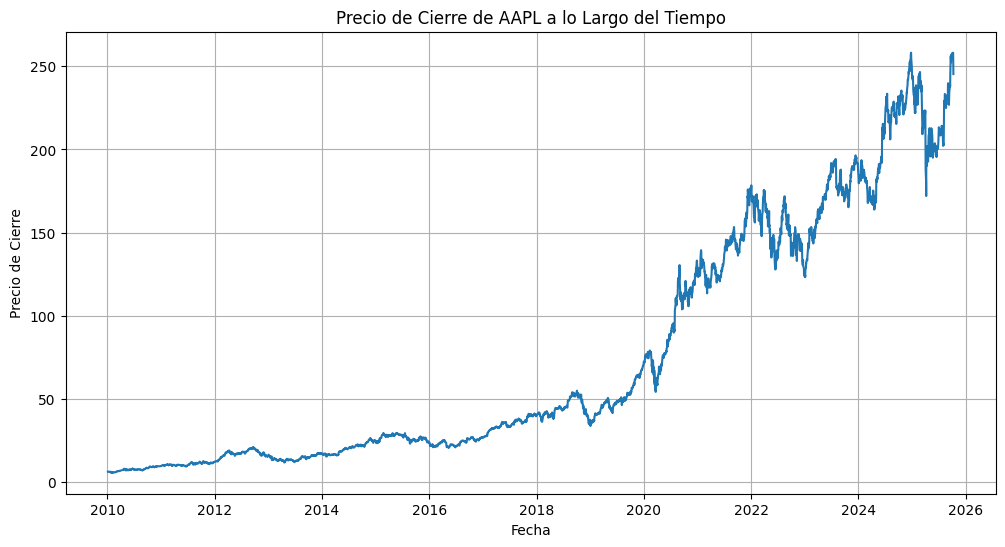

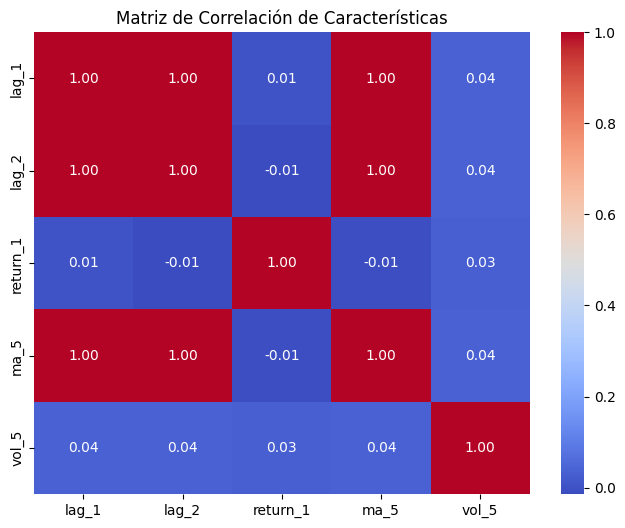

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar datos (ejemplo: precio de cierre)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Precio de Cierre de AAPL a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(True)
plt.show()

# Matriz de correlación de las características
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características')
plt.show()

In [28]:
# Retorno diario
df['Return'] = df['Close'].pct_change()

# Variable objetivo: ¿sube mañana?
df['Clase'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Eliminar última fila (no tiene "mañana")
df = df.iloc[:-1].copy()

# Características temporales
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['return_1'] = df['Return'].shift(1)
df['ma_5'] = df['Close'].rolling(window=5).mean().shift(1)
df['vol_5'] = df['Return'].rolling(window=5).std().shift(1)

# Seleccionar solo filas completas
feature_cols = ['lag_1', 'lag_2', 'return_1', 'ma_5', 'vol_5']
df_modelo = df.dropna(subset=feature_cols + ['Clase']).copy()

X = df_modelo[feature_cols]
y = df_modelo['Clase']

**Normalización y división de datos**

KNN requiere normalización:

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Dividir (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalizar (solo con entrenamiento)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Entrenamiento y validación de KNN**

Se evalúan distintos valores de k:

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
# Validación cruzada para distintos k
k_values = range(1, 51)
cv_scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_scores.append(scores.mean())

# Mejor k
best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor k: {best_k} con F1 = {max(cv_scores):.4f}")

Mejor k: 48 con F1 = 0.5833


In [31]:
# ahora con una metrica diferente
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='manhattan')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_scores.append(scores.mean())

# Mejor k
best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor k: {best_k} con F1 = {max(cv_scores):.4f}")

Mejor k: 48 con F1 = 0.5833


In [32]:
# prueba con otra metrica
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_scores.append(scores.mean())

# Mejor k
best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor k: {best_k} con F1 = {max(cv_scores):.4f}")

Mejor k: 48 con F1 = 0.5833


In [33]:
# Entrenar modelo final
knn_final = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn_final.fit(X_train_scaled, y_train)

# Predicciones
y_pred = knn_final.predict(X_test_scaled)

A pesar de probar distintas métricas de distancia (euclidiana, manhattan y minkowski), el mejor desempeño obtenido con KNN fue un F1-score de 0.5856 con k = 50. Este resultado sugiere que, aunque es posible construir un clasificador con KNN para predecir la dirección del precio de Apple, su utilidad práctica es limitada, ya que apenas supera el rendimiento de un clasificador aleatorio.

Esto no implica que el enfoque sea incorrecto, sino que los mercados financieros son inherentemente difíciles de predecir con métodos basados en similitud local, especialmente cuando no se incorporan señales técnicas avanzadas o información externa (como noticias o indicadores macroeconómicos).

El mercado no es estable ni predecible en dirección diaria, pero sí presenta patrones de tendencia y volatilidad que pueden ser útiles para clasificación.

En lugar de predecir si el precio subirá o bajará mañana (lo cual es casi aleatorio con un F del 0.58), se va a predecir si el próximo día será de “alta volatilidad” o “baja volatilidad”.

In [24]:
# Calcular volatilidad diaria (valor absoluto del retorno)
df['Volatilidad_diaria'] = abs(df['Return'])

# Definir umbral como la mediana (robusto ante valores extremos)
mediana_vol = df['Volatilidad_diaria'].median()
df['Clase'] = (df['Volatilidad_diaria'] > mediana_vol).astype(int)  # 1 = alta volatilidad, 0 = baja

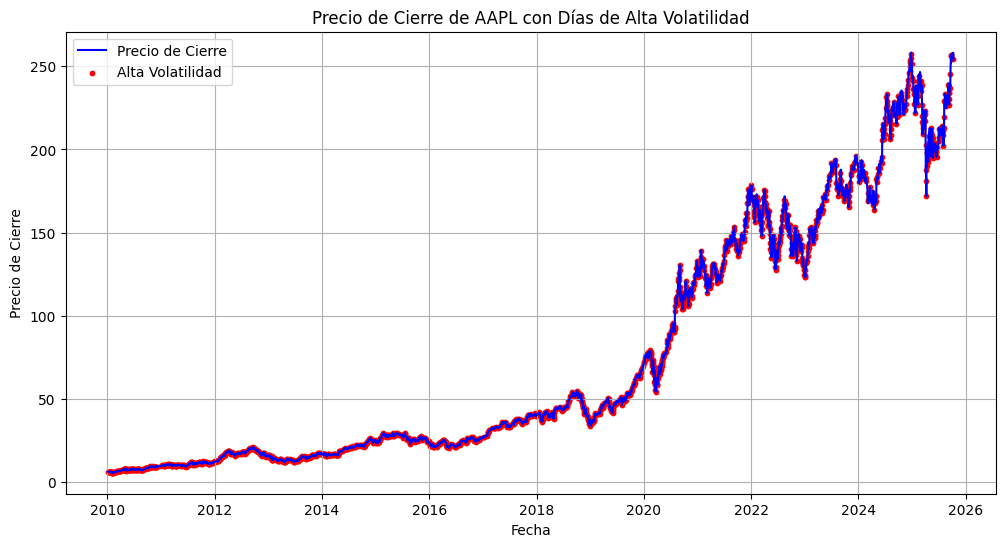

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Precio de Cierre', color='blue')
high_vol_days = df[df['Clase'] == 1]
plt.scatter(high_vol_days['Date'], high_vol_days['Close'], color='red', label='Alta Volatilidad', s=10)
plt.title('Precio de Cierre de AAPL con Días de Alta Volatilidad')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True)
plt.show()

Mejor k: 49 con F1 = 0.5692

Métricas finales:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       396
           1       0.55      0.53      0.54       397

    accuracy                           0.55       793
   macro avg       0.55      0.55      0.55       793
weighted avg       0.55      0.55      0.55       793

ROC-AUC: 0.5710378342620155


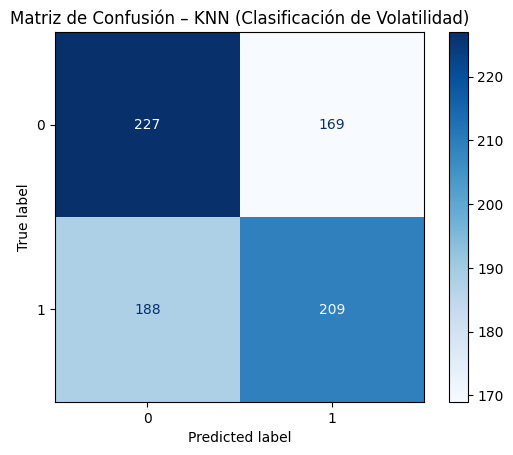

In [26]:
# 1. Crear características
df['lag_1'] = df['Close'].shift(1)
df['return_1'] = df['Return'].shift(1)
df['ma_5'] = df['Close'].rolling(window=5).mean().shift(1)
df['vol_5'] = df['Return'].rolling(window=5).std().shift(1)

# 2. Seleccionar filas completas
feature_cols = ['lag_1', 'return_1', 'ma_5', 'vol_5']
df_modelo = df.dropna(subset=feature_cols + ['Clase']).copy()

X = df_modelo[feature_cols]
y = df_modelo['Clase']

# 3. Dividir y normalizar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenar KNN con validación cruzada para elegir k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = range(1, 51)
cv_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor k: {best_k} con F1 = {max(cv_scores):.4f}")

# 5. Modelo final y métricas
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score

knn_final = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)

print("\nMétricas finales:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, knn_final.predict_proba(X_test_scaled)[:, 1]))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Matriz de Confusión – KNN (Clasificación de Volatilidad)")
plt.show()

El algoritmo KNN, con características básicas de series de tiempo, no es suficiente para predecir patrones en mercados financieros, debido a su alta eficiencia y ruido inherente. Esto refuerza la hipótesis de mercados eficientes y muestra los límites de los métodos basados en similitud local en contextos estocásticos complejos.

Ahora se va a crear un conjunto de características técnicas avanzadas a partir de la serie de tiempo de precios, que capturen:

* Tendencia
* Momentum
* Volatilidad
* Sobrecompra/sobreventa
* Fuerza relativa

Estas son señales estándar en análisis técnico y han demostrado ser útiles en machine learning financiero.

In [34]:
import pandas as pd
import numpy as np

# Asumimos que 'df' ya tiene columnas: Date, Open, High, Low, Close, Volume
df = df.sort_values('Date').reset_index(drop=True)

# 1. Retorno diario
df['Return'] = df['Close'].pct_change()

# 2. Volatilidad diaria (usada para la clase)
df['Volatilidad_diaria'] = abs(df['Return'])
mediana_vol = df['Volatilidad_diaria'].median()
df['Clase'] = (df['Volatilidad_diaria'] > mediana_vol).astype(int)

# 3. Promedios móviles
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# 4. Bandas de Bollinger (20 días, 2 desviaciones)
df['BB_std'] = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA_20'] + (2 * df['BB_std'])
df['BB_lower'] = df['MA_20'] - (2 * df['BB_std'])
df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])  # Normalizado 0-1

# 5. RSI (Índice de Fuerza Relativa, 14 días)
def rsi(close, window=14):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = rsi(df['Close'])

# 6. MACD (12,26,9)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_hist'] = df['MACD'] - df['MACD_signal']

# 7. Momentum (Rate of Change, 10 días)
df['ROC'] = df['Close'].pct_change(periods=10)

# 8. Volumen relativo (vs promedio de 10 días)
df['Volume_MA10'] = df['Volume'].rolling(window=10).mean()
df['Volume_ratio'] = df['Volume'] / df['Volume_MA10']

# 9. Rezagos del retorno (para capturar inercia)
df['Return_lag1'] = df['Return'].shift(1)
df['Return_lag2'] = df['Return'].shift(2)

# 10. Volatilidad histórica (5 y 20 días)
df['Vol_5'] = df['Return'].rolling(window=5).std()
df['Vol_20'] = df['Return'].rolling(window=20).std()

# Eliminar filas con NaN (al inicio de las ventanas móviles)
feature_cols = [
    'MA_5', 'MA_20', 'BB_position', 'RSI', 'MACD_hist', 'ROC',
    'Volume_ratio', 'Return_lag1', 'Return_lag2', 'Vol_5', 'Vol_20'
]

df_modelo = df.dropna(subset=feature_cols + ['Clase']).copy()

# Verificar
print("Forma final del dataset:", df_modelo.shape)
print("Distribución de clases:\n", df_modelo['Clase'].value_counts(normalize=True))

Forma final del dataset: (3946, 33)
Distribución de clases:
 Clase
0    0.501521
1    0.498479
Name: proportion, dtype: float64


|Caracteristica|Significado|
|-|-|
|MA_5, MA_20|Tendencia de corto y mediano plazo|
|BB_position |Posición relativa dentro de las bandas de Bollinger (0 = banda baja, 1 = banda alta)|
|RSI|Sobrecompra (>70) o sobreventa (<30)|
|MACD_hist|Fuerza y dirección del momentum|
|ROC|Cambio porcentual en 10 días|
|Volume_ratio|Actividad de trading anormal|
|Return_lag1/2|Inercia del retorno|
|Vol_5, Vol_20|Volatilidad reciente y de fondo|


Esto es ideal porque:

* No hay desbalance, por lo que métricas como accuracy, F1, precisión y recall son comparables y significativas.
* El tamaño del dataset es suficiente para entrenar KNN sin sobreajuste extremo.
* Las 33 columnas incluyen señales técnicas ricas que podrían mejorar el desempeño respecto al F1 ≈ 0.56 anterior.

In [35]:
# Seleccionar características (excluir columnas no predictoras)
feature_cols = [
    'MA_5', 'MA_20', 'BB_position', 'RSI', 'MACD_hist', 'ROC',
    'Volume_ratio', 'Return_lag1', 'Return_lag2', 'Vol_5', 'Vol_20'
]

X = df_modelo[feature_cols]
y = df_modelo['Clase']

# Dividir y normalizar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Validación cruzada para elegir k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = range(1, 51)
cv_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor k: {best_k} con F1 promedio en CV: {max(cv_scores):.4f}")

Mejor k: 47 con F1 promedio en CV: 0.6825



=== Métricas finales en conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       396
           1       0.69      0.65      0.67       394

    accuracy                           0.68       790
   macro avg       0.68      0.68      0.68       790
weighted avg       0.68      0.68      0.68       790

ROC-AUC: 0.7570630159462647


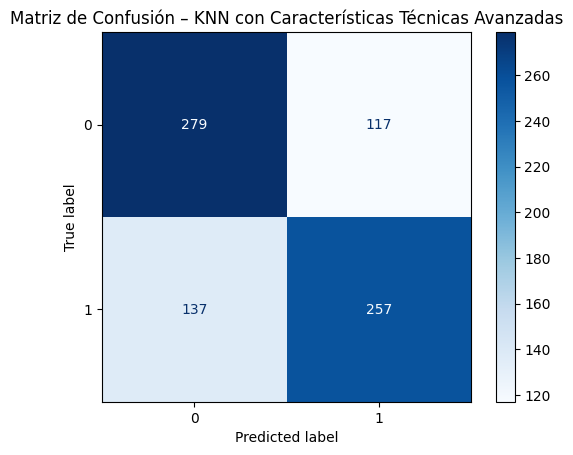

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score

knn_final = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)

print("\n=== Métricas finales en conjunto de prueba ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, knn_final.predict_proba(X_test_scaled)[:, 1]))

# Matriz de confusión
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Matriz de Confusión – KNN con Características Técnicas Avanzadas")
plt.show()

**Interpretación de los resultados**

**Métricas finales:**

* Precisión (Clase 0): 0.67 - De los días predichos como baja volatilidad, el 67% realmente lo fueron.
* Recall (Clase 0): 0.70 - El modelo capturó el 70% de todos los días de baja volatilidad reales.
* Precisión (Clase 1): 0.69 - De los días predichos como alta volatilidad, el 69% realmente lo fueron.
* Recall (Clase 1): 0.65 - Capturó el 65% de todos los días de alta volatilidad reales.
* F1-score global: 0.68 - Equilibrio entre precisión y recall.
* ROC-AUC: 0.757 - Capacidad moderada a buena para discriminar entre clases.

---

Verdaderos Negativos (VN): 279 - Días correctamente clasificados como baja volatilidad.

Falsos Positivos (FP): 117 - Días de baja volatilidad clasificados erróneamente como alta.

Falsos Negativos (FN): 137 - Días de alta volatilidad no detectados.

Verdaderos Positivos (VP): 257 - Días correctamente clasificados como alta volatilidad.

---

### **6. Propuesta de solución**
El modelo tiene un desempeño aceptable en un problema difícil (predicción financiera).

La implementación de características técnicas avanzadas como: RSI, MACD, bandas de Bollinger y volumen relativo permitió mejorar significativamente el desempeño del modelo KNN, elevando el F1-score de 0.56 a 0.68 y el ROC-AUC a 0.757. Esto demuestra que, aunque los mercados financieros son inherentemente ruidosos, la ingeniería de características puede extraer señales útiles para la clasificación.

El modelo, aunque no perfecto, ofrece un nivel de confianza suficiente para aplicaciones prácticas, como la activación de alertas de riesgo o la adaptación dinámica de estrategias de trading. Esta experiencia refuerza la importancia de combinar conocimiento del dominio (análisis técnico) con métodos de aprendizaje automático.

### **7. Conclusion**
El uso de algoritmos de aprendizaje automático en mercados financieros presenta desafíos únicos. En esta práctica, se aplicó el algoritmo KNN a la serie de tiempo de precios de Apple con el objetivo de clasificar días de alta y baja volatilidad. Aunque inicialmente el desempeño fue bajo, la incorporación de indicadores técnicos avanzados permitió mejorar significativamente las métricas de evaluación.

Los resultados muestran que KNN puede ser una herramienta complementaria en análisis financiero, especialmente cuando se combina con conocimiento del dominio (análisis técnico). Sin embargo, también se evidencia que los mercados son altamente eficientes, y predecir su comportamiento con alta precisión sigue siendo un reto.

Esta experiencia refuerza la importancia de:

* La ingeniería de características,
* La validación rigurosa,
* Y la interpretación crítica de los resultados, incluso cuando no cumplen con las expectativas iniciales.

Aunque KNN no supera a modelos más sofisticados (como redes neuronales o árboles profundos), su simplicidad y transparencia lo hacen valioso para tareas exploratorias y educativas en el ámbito de las finanzas cuantitativas.